In [214]:
from datetime import datetime
import os, warnings, pickle, glob
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bambi import Model
import pymc3 as pm

sns.set(style="ticks",font="Arial",font_scale=2)
sns.set_context("poster")

# Experiment One

In [217]:
certain = np.random.normal(0.6,0.05,10000)
uncertain = np.random.normal(0.6,0.2,10000)
obj = np.random.uniform(0,1.2,10000)

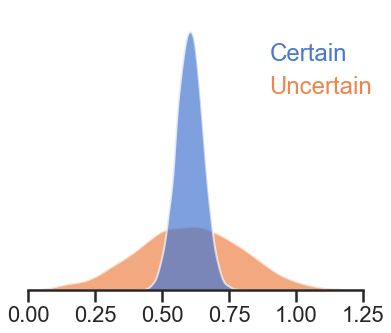

In [218]:
f, axes = plt.subplots(1,1,figsize=(6,5))
sns.kdeplot(uncertain,color=sns.color_palette("muted")[1],shade=True,linewidth=0.1,alpha=0.7)
sns.kdeplot(certain,color=sns.color_palette("muted")[0],shade=True,linewidth=0.1,alpha=0.7)
sns.despine(left=True)
plt.text(0.9,7,"Certain",color=sns.color_palette("muted")[0])
plt.text(0.9,6,"Uncertain",color=sns.color_palette("muted")[1])
axes.set_xlim(0,1.25)
axes.set_yticks([]);
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp1_circle_distributions.pdf")

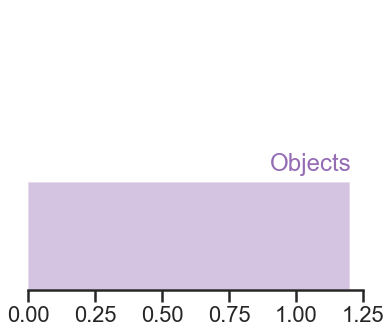

In [221]:
f, axes = plt.subplots(1,1,figsize=(6,5))
sns.distplot(obj,color=sns.color_palette("muted")[4],bins=1,kde=False)
sns.despine(left=True)
plt.text(0.9,11000,"Objects",color=sns.color_palette("muted")[4])
axes.set_xlim(0,1.25)
axes.set_ylim(0,25000)
axes.set_yticks([]);
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp1_object_distributions.pdf")

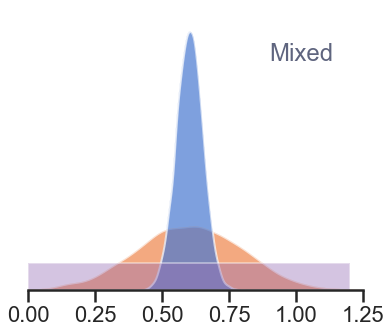

In [222]:
f, axes = plt.subplots(1,1,figsize=(6,5))
sns.kdeplot(uncertain,color=sns.color_palette("muted")[1],shade=True,linewidth=0.1,alpha=0.7)
sns.kdeplot(certain,color=sns.color_palette("muted")[0],shade=True,linewidth=0.1,alpha=0.7)
sns.distplot(obj,color=sns.color_palette("muted")[4],bins=1,kde_kws={"linewidth":0})
plt.text(0.9,7,"Mixed",color=sns.color_palette("bone")[2])
axes.set_yticks([]);
axes.set_xlim(0,1.25)
sns.despine(left=True)
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp1_mixed.pdf")

In [228]:
test_data = pd.read_csv("/Users/jonathan/Desktop/noisyoneshot/data/study1_testdata.csv")
old_data = test_data[test_data.old_trial == True]
old_data['old_value'] = old_data['old_value'].astype('float')
old_data = old_data.loc[old_data.index[old_data['prop_response'] >= 0.9]]

# Effect code certainty of incremental cue
l, u = pd.factorize(old_data.circle)
l = np.where(l==0, -1, l)
old_data['certainty_effect'] = l

# Mean center old value
mean_vals = old_data.groupby(["subjectID"]).old_value.mean().reset_index(name="old_val_mean")
ov_centered = []
for i_row, row in old_data.iterrows():
    subj_centers = mean_vals[mean_vals.subjectID == row.subjectID]
    ov = row.old_value - subj_centers["old_val_mean"].iloc[0]    
    ov_centered.append(ov)
old_data["old_value_centered"] = ov_centered

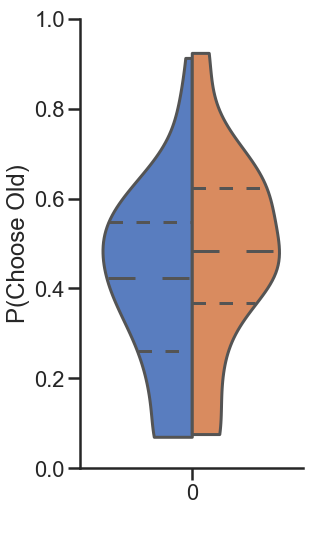

In [225]:
f, axes = plt.subplots(1,1,figsize=(5,8))
mean_data = old_data.groupby(["subjectID","circle"]).object_chosen.mean().reset_index(name="object_chosen")
mean_data['d'] = [0] * len(mean_data)
g = sns.violinplot(x="d",y="object_chosen",data=mean_data,palette="muted",
                   split=True,hue="circle",inner="quartile",cut=-1)
g.legend_.remove()
g.set_ylabel("P(Choose Old)")
g.set_xlabel(" ")
g.set_ylim(0,1)
sns.despine()

plt.tight_layout()
f.savefig('/Users/jonathan/Desktop/noisyoneshot/figures/exp1_maineffect_test.pdf')

In [229]:
exp1_model = Model(old_data, dropna=True)

exp1_model_fit = exp1_model.fit("object_chosen ~ certainty_effect*old_value_centered",
                                random=['certainty_effect*old_value_centered|subjectID'], family='bernoulli',
                                samples=2000, chains=4, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 13,750:  69%|██████▊   | 34298/50000 [03:06<01:25, 184.14it/s]
Convergence achieved at 34300
Interrupted at 34,299 [68%]: Average Loss = 14,519
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [certainty_effect:old_value_centered|subjectID_offset, certainty_effect:old_value_centered|subjectID_sd, old_value_centered|subjectID_offset, old_value_centered|subjectID_sd, certainty_effect|subjectID_offset, certainty_effect|subjectID_sd, 1|subjectID_offset, 1|subjectID_sd, certainty_effect:old_value_centered, old_value_centered, certainty_effect, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [04:10<00:00, 15.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


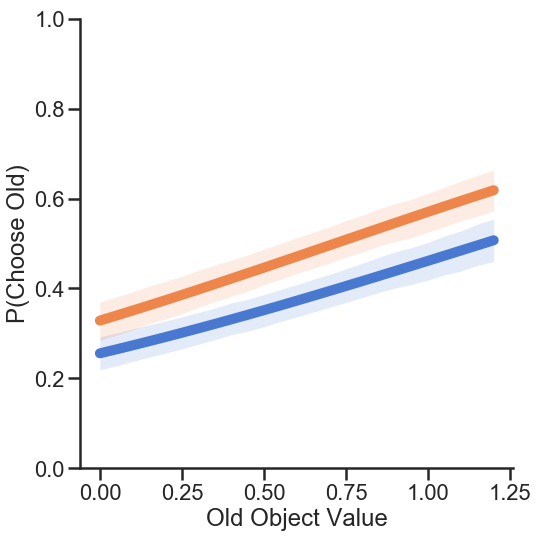

In [242]:
trace_df = exp1_model_fit.to_df()

f, axes = plt.subplots(1,1,figsize=(8,8))

circles = [-1, 1] #-1 is max, 1 is min
values = [x * 0.01 for x in range(-60,65,5)]
for circle_i, circle in enumerate(circles):
    lows, highs, mean_ps = [],[],[]
    for i, val in enumerate(values):
        xb = trace_df["Intercept"] + \
             val*trace_df['old_value_centered'] + \
             circle*trace_df["certainty_effect"] + \
             val*circle*trace_df["certainty_effect:old_value_centered"]
        
        p = np.exp(xb) / (1 + np.exp(xb))

        hpd = pm.stats.hpd(p)

        lows.append(hpd[0])
        highs.append(hpd[1])
        mean_ps.append(np.mean(p))

    rescaled_values = [v + 0.6 for v in values]
    axes.plot(rescaled_values,mean_ps,color=sns.color_palette("muted")[circle_i],linewidth=10)
    axes.set_ylim(0,1)
    axes.fill_between(rescaled_values, lows, highs, color=sns.color_palette("muted")[circle_i],alpha=0.15,linewidth=0)
    axes.set_ylabel("P(Choose Old)")
    axes.set_xlabel("Old Object Value")

plt.tight_layout()
sns.despine()
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp1_results_fig.pdf")

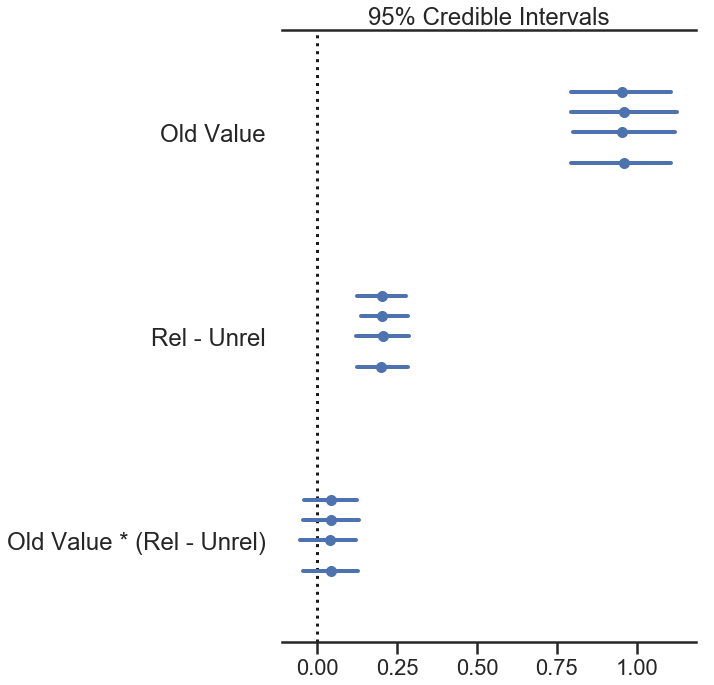

In [239]:
sns.set(style="ticks",font="Arial",font_scale=2)
sns.set_context("poster")
plt.subplots(1,1,figsize=(10,10))
f = pm.forestplot(exp1_model.backend.trace, rhat=False, quartiles=False,plot_kwargs={"markersize":10,"linewidth":8},
              ylabels=["Old Value", "Rel - Unrel", "Old Value * (Rel - Unrel)"],
              varnames=['old_value_centered','certainty_effect','certainty_effect:old_value_centered'])
plt.tight_layout()
plt.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp1_model_effects.pdf");

In [240]:
pm.waic(exp1_model.backend.trace, exp1_model.backend.model)

WAIC_r(WAIC=26511.037348917074, WAIC_se=127.29646193908751, p_WAIC=609.0016233403214, var_warn=1)

In [241]:
hpd = pm.stats.hpd(exp1_model.backend.trace,alpha=0.05)[0]['old_value_centered']
print(hpd,np.mean(exp1_model.backend.trace['old_value_centered']))

hpd = pm.stats.hpd(exp1_model.backend.trace,alpha=0.05)[0]['certainty_effect']
print(hpd,np.mean(exp1_model.backend.trace['certainty_effect']))

hpd = pm.stats.hpd(exp1_model.backend.trace,alpha=0.05)[0]['certainty_effect:old_value_centered']
print(hpd,np.mean(exp1_model.backend.trace['certainty_effect:old_value_centered']))

[0.80193599 1.12036871] 0.9583960452956632
[0.12190153 0.28582586] 0.20245123177095548
[-0.053024    0.12219262] 0.04219513203369145


---
# Experiment Two

In [243]:
minDiscrete = [0.0,
               0.2,0.2,
               0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,
               0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,
               0.8,0.8,
               1.0]

maxDiscrete = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
               0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
               0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,
               0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,
               0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,
               1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

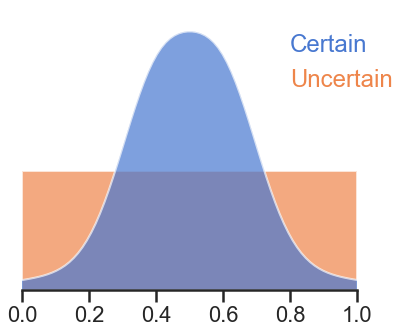

In [244]:
f, axes = plt.subplots(1,1,figsize=(6,5))

sns.distplot(maxDiscrete,color=sns.color_palette("muted")[1],bins=1,kde_kws={"linewidth":0},hist_kws={"alpha":0.7})
sns.kdeplot(minDiscrete,color=sns.color_palette("muted")[0],shade=True,linewidth=0.1,alpha=0.7,bw=0.11,zorder=2)
sns.despine(left=True)
plt.text(0.8,2,"Certain",color=sns.color_palette("muted")[0])
plt.text(0.8,1.7,"Uncertain",color=sns.color_palette("muted")[1])
axes.set_xlim(0,1)
axes.set_yticks([]);
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp2_deck_distributions.pdf")

In [246]:
# Load all datasets
n_subjects, data = loadData()
# Exclude participants for performance
data = data[~data.subject_id.isin(["92216","43388","40958","50179","77464","82642"])]
n_subjects = len(data.subject_id.unique())

# Clean data
data = data[data.phase == "choice"]
data["old_value"] = data["old_value"].astype("float")
data = data[data.choice != "no_response"]
data["value"] = data["value"].astype("float")
data["risky_chosen"] = data["risky_chosen"].astype("float")

# Separate data with and without old objects
old_data_exp2 = data[data.old_trial == True]
old_data_exp2["old_value"] = old_data_exp2["old_value"].astype("float")
old_data_exp2["old_chosen"] = old_data_exp2["old_chosen"].astype("float")
new_data = data[data.old_trial == False]

# Effect code by learning time
old_data_learningtime = bin_by_learning_time(n_bins=2)
l, u = pd.factorize(old_data_learningtime.learning_time)
l = np.where(l==0, -1, l)
old_data_exp2['learning_effect'] = l

# Effect code by deck certainty
l, u = pd.factorize(old_data_exp2.old_risk)
l = np.where(l==0, -1, l)
old_data_exp2['certainty_effect'] = l

# Mean center old value
mean_vals = old_data_exp2.groupby(["subject_id"]).old_value.mean().reset_index(name="old_val_mean")
ov_centered = []
for i_row, row in old_data_exp2.iterrows():
    subj_centers = mean_vals[mean_vals.subject_id == row.subject_id]
    ov = row.old_value - subj_centers["old_val_mean"].iloc[0]
    ov_centered.append(ov)
old_data_exp2["old_value_centered"] = ov_centered

In [247]:
# Full 3-Way Effect Coded Model
exp2_model = Model(old_data_exp2, dropna=True)

exp2_model_fit = exp2_model.fit("old_chosen ~ old_value_centered*certainty_effect*learning_effect",
                                random=['old_value_centered*certainty_effect*learning_effect|subject_id'], family='bernoulli',
                                samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 5,822.3:  69%|██████▉   | 34578/50000 [02:26<01:05, 236.74it/s]
Convergence achieved at 34600
Interrupted at 34,599 [69%]: Average Loss = 6,335.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [old_value_centered:certainty_effect:learning_effect|subject_id_offset, old_value_centered:certainty_effect:learning_effect|subject_id_sd, certainty_effect:learning_effect|subject_id_offset, certainty_effect:learning_effect|subject_id_sd, old_value_centered:learning_effect|subject_id_offset, old_value_centered:learning_effect|subject_id_sd, learning_effect|subject_id_offset, learning_effect|subject_id_sd, old_value_centered:certainty_effect|subject_id_offset, old_value_centered:certainty_effect|subject_id_sd, certainty_effect|subject_id_offset, certainty_effect|subject_id_sd, old_value_centered|subject_id_offset, old_value_centered|subject_id_sd, 1|subject_id_offset, 1|subject_id_sd, old_value_centered:certainty_effec

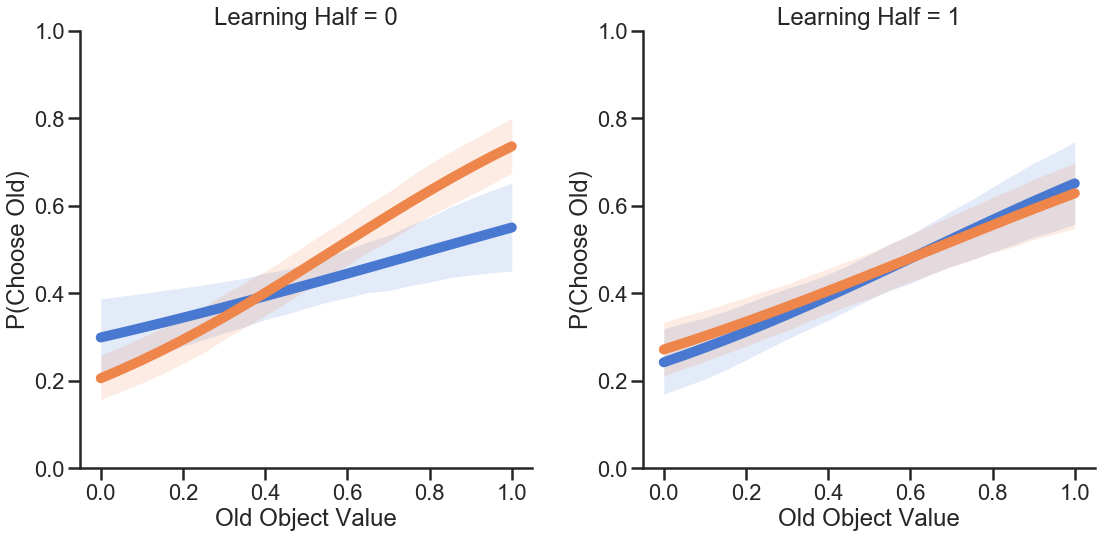

In [249]:
trace_df = exp2_model_fit.to_df()

f, axes = plt.subplots(1,2,figsize=(16,8))

learn_time = [-1, 1] # -1 is early, 1 is late
decks = [1, -1] #-1 is max, 1 is min
values = [x * 0.01 for x in range(-50,55,5)]
for time_i, time in enumerate(learn_time):
    for deck_i, deck in enumerate(decks):
        lows, highs, mean_ps = [],[],[]
        for i, val in enumerate(values):
            xb = trace_df["Intercept"] + \
                 val*trace_df['old_value_centered'] + \
                 deck*trace_df["certainty_effect"] + \
                 val*deck*trace_df["old_value_centered:certainty_effect"] + \
                 deck*time*trace_df["certainty_effect:learning_effect"] + \
                 val*time*trace_df["old_value_centered:learning_effect"] + \
                 val*deck*time*trace_df["old_value_centered:certainty_effect:learning_effect"]

            p = np.exp(xb) / (1 + np.exp(xb))

            hpd = pm.stats.hpd(p)

            lows.append(hpd[0])
            highs.append(hpd[1])
            mean_ps.append(np.mean(p))

        rescaled_values = [v + 0.5 for v in values]
        axes[time_i].plot(rescaled_values,mean_ps,color=sns.color_palette("muted")[deck_i],linewidth=10)
        axes[time_i].set_ylim(0,1)
        axes[time_i].fill_between(rescaled_values, lows, highs, color=sns.color_palette("muted")[deck_i],alpha=0.15,linewidth=0)
        axes[time_i].set_title("Learning Half = %s"%(time_i))
        axes[time_i].set_ylabel("P(Choose Old)")
        axes[time_i].set_xlabel("Old Object Value")

plt.tight_layout()
sns.despine()
f.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp2_results_fig.pdf")

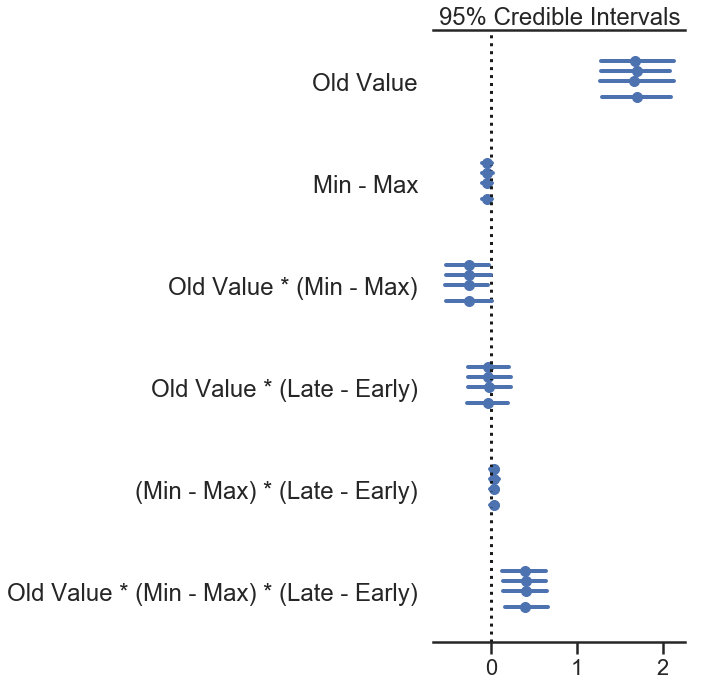

In [251]:
sns.set(style="ticks",font="Arial",font_scale=2)
sns.set_context("poster")
plt.subplots(1,1,figsize=(10,10))
f = pm.forestplot(exp2_model.backend.trace, rhat=False, quartiles=False,plot_kwargs={"markersize":10,"linewidth":8},
              ylabels=["Old Value", "Min - Max", "Old Value * (Min - Max)",
                       "Old Value * (Late - Early)","(Min - Max) * (Late - Early)",
                       "Old Value * (Min - Max) * (Late - Early)"],
              varnames=['old_value_centered','certainty_effect','old_value_centered:certainty_effect',
                        'old_value_centered:learning_effect','certainty_effect:learning_effect','old_value_centered:certainty_effect:learning_effect'])
plt.tight_layout()
plt.savefig("/Users/jonathan/Desktop/noisyoneshot/figures/exp2_model_effects.pdf");

In [254]:
hpd = pm.stats.hpd(exp2_model.backend.trace,alpha=0.05)[0]['old_value_centered']
print(hpd,np.mean(exp2_model.backend.trace['old_value_centered']))

hpd = pm.stats.hpd(exp2_model.backend.trace,alpha=0.05)[0]['old_value_centered:certainty_effect']
print(hpd,np.mean(exp2_model.backend.trace['old_value_centered:certainty_effect']))

hpd = pm.stats.hpd(exp2_model.backend.trace,alpha=0.05)[0]['old_value_centered:certainty_effect:learning_effect']
print(hpd,np.mean(exp2_model.backend.trace['old_value_centered:certainty_effect:learning_effect']))

[1.26147429 2.12459339] 1.6893493417781442
[-0.54275931 -0.03863871] -0.2656215296724092
[0.1394321  0.64744699] 0.39620531331733777


In [253]:
pm.waic(exp2_model.backend.trace, exp2_model.backend.model)

WAIC_r(WAIC=11268.551377959418, WAIC_se=76.69535597236298, p_WAIC=288.06363539464445, var_warn=1)

In [245]:
def bin_by_learning_time(n_bins=None):
    old_data_learningtime = []
    for pid in old_data_exp2.subject_id.unique():
        pid_data = old_data_exp2[old_data_exp2.subject_id == pid]
        pid_data['learning_time'] = pd.cut(pid_data.trial_number,n_bins,labels=range(n_bins))
        old_data_learningtime.append(pid_data)
    old_data_learningtime = pd.concat(old_data_learningtime)
    return old_data_learningtime

def loadData():
    data_dir = "/users/jonathan/Desktop/oneshot-risk/task/data"
    pid_files = glob.glob(os.path.join(data_dir,"*_experiment_data.csv"))
    n_subjects = len(pid_files)
    full_data = pd.concat([pd.read_csv(file) for file in pid_files])
    
    return n_subjects, full_data